# Connecting FEniCS and QMCPy Demo

In [1]:
from dolfin import *
import time
import numpy as np
import math
set_log_active(False)

Defining a mesh as well as degree count for a later function

In [2]:
deg = 6
n = 10
mesh = UnitIntervalMesh(n)

Defining boundary conditions needed for FEM solving

In [3]:
def my_boundary(x): #0 or 1
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

In [4]:
V = FunctionSpace(mesh, "CG", 1)
u0 = Constant(0)
bc = DirichletBC(V, u0, my_boundary)

The trial function is the function that gets turned into the function we're looking for when we do FEM. The test function is an additional function that gets used when turning our equation into variational form

In [5]:
u = TrialFunction(V)
v = TestFunction(V)

This is where we define the sum of Chebyshev polynomials. We begin with an array of coeffecients (which we replace with QMCPy-supplied random values later). 

In [6]:
coeffs = Constant((1,) * deg)

Then we have an array of Chebyshev polynomials here 

In [7]:
expr_array = [0] * deg
for i in range(deg):
    expr_array[i] = Expression("cos(n*acos( (2*x[0])-1 ))", n=i, degree=1)

Here is where we combine the two. We multiply each element in the array of Chebychev polynomials with an element of the array of coefficient objects, multiplied also by a dampening factor depending on the index of the element. We also take the entire sum and further dampen it by the beta value and add 1 to ensure that the final value is well above zero, to prevent any unusual behavior. 

In [8]:
a3 = 0
beta = 0.1
for i in range(deg):
    a3 += coeffs[i]*expr_array[i]*(1/((i+1)**2))
a3 = 1+(beta*a3)

We now write out the variational form of the equation we're trying to solve. The final equation will be a4 == L

In [9]:
a4 = (a3*inner(grad(u), grad(v)))*dx

In [10]:
f = Expression("sin(pi*x[0])", degree=1)

In [11]:
L = f*v*dx

In [12]:
u = Function(V)

In [13]:
coeffs

Coefficient(FunctionSpace(None, VectorElement(FiniteElement('Real', None, 0), dim=6)), 7)

In [14]:
solve(a4 == L, u, bc)

If the above cell worked without error, then that means it found a solution u(x) and we can extract both a value of u at a point of interest or a graph of all of u

In [15]:
u(0.5)

0.09150650356987186

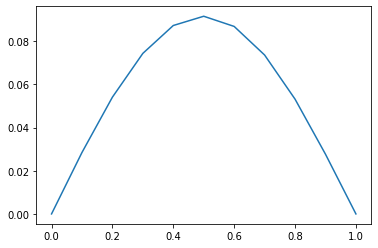

In [16]:
plot(u)

Now we use QMCPy to supply random samples of a distribution of our choice to replace the coefficients we defined in the coefficient array above. We used both iid sample and sobol samples to compare how long it takes for using the 2 methods

In [17]:
import random
import qmcpy as qp

In [40]:
num_samples = 2**5

In [41]:
iid = qp.Uniform(qp.IIDStdUniform(dimension=deg, seed=None), lower_bound=-1, upper_bound=1)
iid_samples = iid.gen_samples(num_samples) #Get samples of uniformly distributed random values

In [42]:
ld = qp.Uniform(qp.Sobol(dimension=deg), lower_bound=-1, upper_bound=1)
ld_samples = ld.gen_samples(num_samples)

In [21]:
len(ld_samples[0])

6

This function does the same as what we did before importing qmcpy, but all in one function which we can call later on

In [22]:
def solve_poisson(samples):
    ret = [0] * len(samples)
    
    n = 10
    mesh = UnitIntervalMesh(n)
    def my_boundary(x): #0 or 1
        return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
    V = FunctionSpace(mesh, "CG", 1)
    u0 = Constant(0)
    bc = DirichletBC(V, u0, my_boundary)
    u = TrialFunction(V)
    v = TestFunction(V)
    #f = Expression("sin(pi*x[0])", degree=1) 
    #f = Expression("x[0]-0.5", degree=1) 
    f = Expression("sin(pi*x[0])", degree=1) 
    L = f*v*dx
    
    deg = len(samples[0])
    expr_array = [0] * deg
    coeffs = Constant((1,) * deg)
    for i in range(deg):
        expr_array[i] = Expression("cos(n*acos( (2*x[0])-1 ))", n=i, degree=1)
    a3 = 0
    beta = 0.8
    for i in range(deg):
        a3 += coeffs[i]*expr_array[i]*(1/((i+1)**2))
    a3 = (Constant(1.0)+(beta*a3))
    a4 = (a3*inner(grad(u), grad(v)))*dx
    
    u = Function(V)
    for i in range(len(samples)):
        coeffs.assign(Constant(samples[i]))
        solve(a4==L, u, bc)
        ret[i] = u(0.25)
    return np.array(ret)

In [32]:
def solve_poisson_and_graph(samples):
    ret = [0] * len(samples)
    
    n = 10
    mesh = UnitIntervalMesh(n)
    def my_boundary(x): #0 or 1
        return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
    V = FunctionSpace(mesh, "CG", 1)
    u0 = Constant(0)
    bc = DirichletBC(V, u0, my_boundary)
    u = TrialFunction(V)
    v = TestFunction(V)
    #f = Expression("sin(pi*x[0])", degree=1) 
    #f = Expression("x[0]-0.5", degree=1) 
    f = Expression("sin(pi*x[0])", degree=1)
    L = f*v*dx
    
    deg = len(samples[0])
    expr_array = [0] * deg
    coeffs = Constant((1,) * deg)
    for i in range(deg):
        expr_array[i] = Expression("cos(n*acos( (2*x[0])-1 ))", n=i, degree=1)
    a3 = 0
    beta = 0.8
    for i in range(deg):
        a3 += coeffs[i]*expr_array[i]*(1/((i+1)**2))
    a3 = (Constant(1.0)+(beta*a3))
    a4 = (a3*inner(grad(u), grad(v)))*dx
    
    u = Function(V)
    for i in range(len(samples)):
        coeffs.assign(Constant(samples[i]))
        solve(a4==L, u, bc)
        plot(u)
        ret[i] = u(0.25)
    return np.array(ret)

Testing the above function, and finding the average of the values in it. We also use a copy of the function that graphs our solutions so we see the various instances of the DE with random coefficients.  

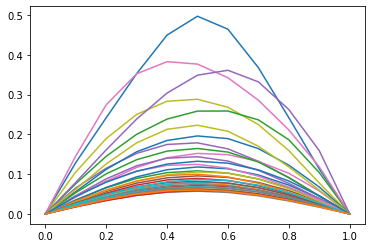

In [43]:
uvec = solve_poisson_and_graph(ld_samples)

In [44]:
sum(uvec)/len(uvec)

0.09983170210988283

Here we time the usage of stopping critereon to determine the number of sample points (as opposed to before when we manually picked the number of points). Notice how much faster sobol points converge to an answer than iid ones. 

In [45]:
%%time
f = qp.CustomFun(ld, g=solve_poisson)
stop = qp.CubQMCSobolG(f, abs_tol = 1e-2)
solution, data = stop.integrate()
print(data)

LDTransformData (AccumulateData Object)
    solution        -1.083
    indv_error      0.007
    ci_low          -1.090
    ci_high         -1.076
    ci_comb_low     -1.090
    ci_comb_high    -1.076
    flags_comb      0
    flags_indv      0
    n_total         2^(10)
    n               2^(10)
    time_integrate  0.811
CubQMCSobolG (StoppingCriterion Object)
    abs_tol         0.010
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
CustomFun (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     -1
    upper_bound     1
Sobol (DiscreteDistribution Object)
    d               6
    dvec            [0 1 2 3 4 5]
    randomize       LMS_DS
    graycode        0
    entropy         263830695067951237984691440566527060058
    spawn_key       ()
CPU times: user 867 ms, sys: 66.3 ms, total: 933 ms
Wall time: 812 ms


In [46]:
%%time
f = qp.CustomFun(iid, g=solve_poisson)
stop = qp.CubMCCLT(f, abs_tol = 1e-2)
solution, data = stop.integrate()
print(data)

MeanVarData (AccumulateData Object)
    solution        -1.069
    error_bound     0.043
    n_total         97065
    n               96041
    levels          1
    time_integrate  69.599
CubMCCLT (StoppingCriterion Object)
    abs_tol         0.010
    rel_tol         0
    n_init          2^(10)
    n_max           10000000000
    inflate         1.200
    alpha           0.010
CustomFun (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     -1
    upper_bound     1
IIDStdUniform (DiscreteDistribution Object)
    d               6
    entropy         200506425314647758813315011312518588572
    spawn_key       ()
CPU times: user 1min 8s, sys: 2.31 s, total: 1min 11s
Wall time: 1min 9s


Here we plot the difference in timing between IID and Sobol points. Notice how much more time IID points take to find the same answer compared to sobol points as error tolerance decreases

In [47]:
xaxislist = [1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3]

In [48]:
def time_solve(useSobol, input_abs_tol):
    if(useSobol):
        f = qp.CustomFun(ld, g=solve_poisson)
        stop = qp.CubQMCSobolG(f, abs_tol = input_abs_tol, n_init=2**8)
        solution, data = stop.integrate()
        #print(data)
    else:
        f = qp.CustomFun(iid, g=solve_poisson)
        stop = qp.CubMCCLT(f, abs_tol = input_abs_tol)
        solution, data = stop.integrate()
        #print(data)
    return data.time_integrate

In [49]:
sobols = []
for i in xaxislist:
    sobols.append(time_solve(True, i))
    print("done for: ", i)

done for:  0.1
done for:  0.05
done for:  0.02
done for:  0.01
done for:  0.005
done for:  0.002
done for:  0.001


Warning: this code cell will take several hours to run

In [50]:
iids = []
for i in xaxislist:
    iids.append(time_solve(False, i))
    print("done for: ", i)

done for:  0.1
done for:  0.05
done for:  0.02
done for:  0.01
done for:  0.005
done for:  0.002
done for:  0.001


In [51]:
import matplotlib.pyplot as plt

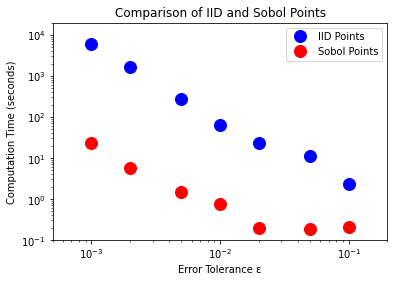

In [54]:
#plt.plot(xaxislist, sobols, 'ro')
plt.loglog(xaxislist, iids, 'bo', label='IID Points', markersize=12)
plt.loglog(xaxislist, sobols, 'ro', label='Sobol Points', markersize=12)
plt.axis([5e-4, 2e-1, 1e-1, 2e4])
plt.xlabel('Error Tolerance ε')
plt.ylabel('Computation Time (seconds)')
plt.title('Comparison of IID and Sobol Points')
plt.legend()
plt.show()